# LSTM on Amazon Fine Food Reviews Data

### Amazon's Fine Food reviews dataset :  https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.
   - Number of reviews: 568,454
   - Number of users: 256,059
   - Number of products: 74,258
   - Timespan: Oct 1999 - Oct 2012
   - Number of Attributes/Columns in data: 10(including class attribute)

Attribute Information:

   - Id
   - ProductId - unique identifier for the product
   - UserId - unqiue identifier for the user
   - ProfileName
   - HelpfulnessNumerator - number of users who found the review helpful
   - HelpfulnessDenominator - Total number of users who indicated whether they found the review helpful or not
   - Time - timestamp for the review
   - Summary - brief summary of the review
   - Text - text of the review
   - Score(Class Label) - rating between 1 and 5 (rating 1 & 2 is negative, rating 4 & 5 is positive and rating 3 is neutral)

### Columns/Attribute created by Cleaning
- Ranked Data: (Refer: "lstm_data_creation.ipynb")
    - amazon_imdb_form_data.pkl - Contains both Train and Test data along with labels in dict format
    - review_length_list.pkl - number of words in each review (for both Train and Test data in dict format)

# 1 Importing Required Libraries

In [1]:
# Importing libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
%matplotlib notebook 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, pickle
import seaborn as sns

## 1.1 Plotting Functions

In [3]:
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax,fig, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [4]:
def _plots(model,history):
    score = model.evaluate(x_test, y_test, verbose=0) 
    print('Test score:', score[0]) 
    print('Test accuracy:', score[1])


    fig,ax = plt.subplots(1,1)

    ax.set_xlabel('epoch') 
    ax.set_ylabel('Categorical Crossentropy Loss')

    # list of epoch numbers
    x = list(range(1,epochs+1))


    vy = history.history['val_loss']
    ty = history.history['loss']
    plt_dynamic(x, vy, ty, ax,fig)

    w_after = model.get_weights()

    h1_w = w_after[0].flatten().reshape(-1,1)
    h2_w = w_after[2].flatten().reshape(-1,1)
    out_w = w_after[4].flatten().reshape(-1,1)

    
    print("Sanity check".center(60))
    plt.figure(figsize=(8,5))
    plt.title("Weight matrices after model trained")
    plt.subplot(1, 3, 1)
    plt.title("Trained model Weights")
    ax = sns.violinplot(y=h1_w,color='b')
    plt.xlabel('Hidden Layer 1')

    plt.subplot(1, 3, 2)
    plt.title("Trained model Weights")
    ax = sns.violinplot(y=h2_w, color='r')
    plt.xlabel('Hidden Layer 2 ')

    plt.subplot(1, 3, 3)
    plt.title("Trained model Weights")
    ax = sns.violinplot(y=out_w,color='y')
    plt.xlabel('Output Layer ')
    plt.show()
    return score[0],score[1]

In [5]:
def result_append(df,wrd):
    """
    Saving the output values of all the model is stored
    in the same excel file. For the final Summary 
    of all the models.
    
    Here, wrd is used like a dict key in order to avoid
    duplicates. Hence, it is mandatory to give same name 
    if we are retraining for same params to avoid 
    confusions between models
    
    input - 2 arguments  
    output - 1 argument
    eg.
    df=result_append(df = results_as_DataFrame,
                     wrd = key_name_of_model )
    """
    
    if not os.path.isfile('./outputs.xlsx'):
        df.to_excel('./outputs.xlsx', sheet_name='sheet1', index=False)
        df1=df
        print('Stored the data in new file')
        
    else:
        df1 = pd.DataFrame()
        df1 = pd.read_excel('./outputs.xlsx')
        
        if (wrd in set(df1['model'])):
            df1.loc[df1['model']==wrd]= df.values
            print('Replacing the data')
        else:
            df1=df1.append(df)
            print('Appending the data')
    
        df1.to_excel('./outputs.xlsx', sheet_name='sheet1', index=False)
    return df1

# 2 Univariate Analysis on number of words in each review

In [6]:
with open( './model/review_length_list.pkl','rb') as fi:
    review_len_list=pickle.load(fi)

train_review_len=review_len_list['train_review_len']
test_review_len=review_len_list['test_review_len']

In [10]:
def percentile_(rang,sample,lbl,r):
    
    print('***'.center(100,'-'))
    
    sa=sorted(sample)
    plt.plot(sa[:r],label=lbl)
    plt.xlabel('feature - '+lbl)
    plt.ylabel('count')
    plt.legend()
    plt.grid()
    plt.show()
    print('***'.center(100,'-'))
    
    for i in rang:   
        p=np.percentile(sample,i )
        print('%.1f th perncentile is: %.2f'%(i,p))
    print('***'.center(100,'-'))    

------------------------------------------------***-------------------------------------------------


<IPython.core.display.Javascript object>


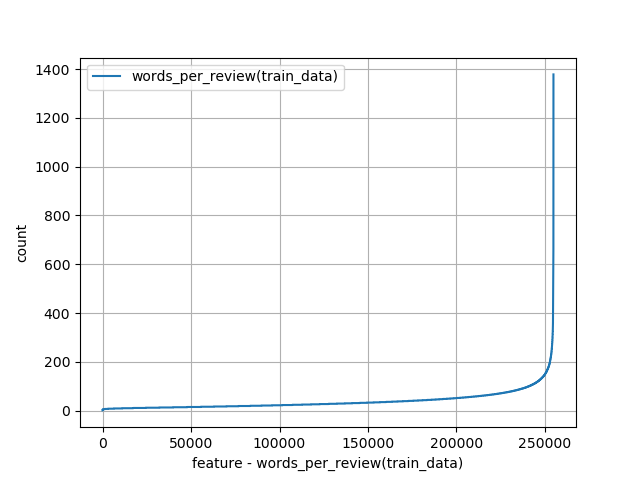

------------------------------------------------***-------------------------------------------------
90.0 th perncentile is: 77.00
91.0 th perncentile is: 80.00
92.0 th perncentile is: 85.00
93.0 th perncentile is: 90.00
94.0 th perncentile is: 96.00
95.0 th perncentile is: 104.00
96.0 th perncentile is: 113.00
97.0 th perncentile is: 127.00
98.0 th perncentile is: 146.00
99.0 th perncentile is: 184.00
100.0 th perncentile is: 1378.00
------------------------------------------------***-------------------------------------------------


In [12]:
percentile_(rang=np.arange(90,101,1),
           sample=train_review_len,
           lbl='words_per_review(train_data)',
           r=400000
           )

## From the above plot, we can consider 128 words for padding as it has covered 97% of entire data/review.

------------------------------------------------***-------------------------------------------------


<IPython.core.display.Javascript object>


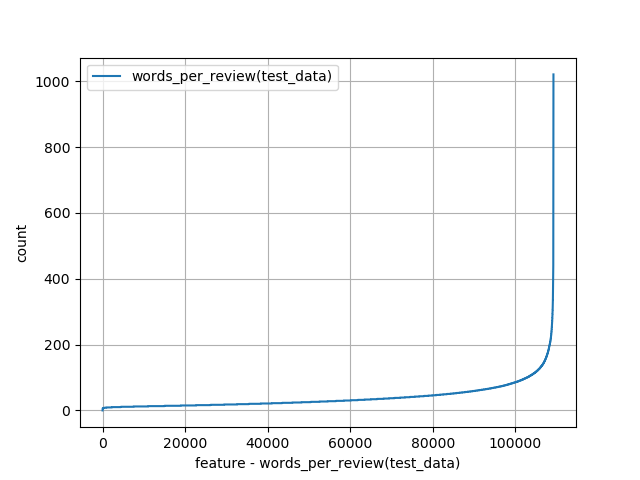

------------------------------------------------***-------------------------------------------------
90.0 th perncentile is: 79.00
91.0 th perncentile is: 83.00
92.0 th perncentile is: 88.00
93.0 th perncentile is: 93.00
94.0 th perncentile is: 99.00
95.0 th perncentile is: 107.00
96.0 th perncentile is: 116.00
97.0 th perncentile is: 129.00
98.0 th perncentile is: 149.00
99.0 th perncentile is: 190.00
100.0 th perncentile is: 1021.00
------------------------------------------------***-------------------------------------------------


In [13]:
# Checking the test data distribution
percentile_(rang=np.arange(90,101,1),
           sample=test_review_len,
           lbl='words_per_review(test_data)',
           r=400000
           )

# 3 Loading saved Data

In [14]:
with open( './model/amazon_imdb_form_data.pkl','rb') as fi:
    x=pickle.load(fi)

x_train=x['train_ranked_data']
x_test=x['test_ranked_data']
y_train=x['y_train']
y_test=x['y_test']

del x

In [15]:
print("Length of x_train :",len(x_train))
print("Length of x_test :",len(x_test))
print("Length of y_train :",len(y_train))
print("Length of y_test :",len(y_test))

Length of x_train : 254786
Length of x_test : 109194
Length of y_train : 254786
Length of y_test : 109194


## 3.2 Padding Train and Test data

In [16]:
# truncate or pad input sequences

# Using the 97th percentile value as discussed above(Refer Section 2)
max_review_length = 128
x_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
x_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

print('Shape of Train data',x_train.shape)
print('Shape of Test data',x_test.shape)
print('Sample review\n',x_train[0])

Shape of Train data (254786, 128)
Shape of Test data (109194, 128)
Sample review
 [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0 15697    30  1029
    14   349  2456  3130 13427  1104  1246   546   105  3675  7323   845
   804 10590  1723 11337     8   177   783  1029  1030  2730  1197  1029
  1523  1832   349    84   255 13427  1357  1670]


## 3.3 Getting length of vocabulary

In [17]:
with open( './model/wrd_rank.pkl','rb') as fi:
    wrd_rank_dict=pickle.load(fi)

vocab_len=len(wrd_rank_dict.keys())
print(vocab_len)

59059


## 3.4 RNN with 1-LSTM layer

In [19]:
embedding_len=32

lstm=Sequential()
lstm.add(Embedding(vocab_len,
                   embedding_len,
                   input_length=max_review_length))

lstm.add(LSTM(100))
lstm.add(Dropout(0.25))

lstm.add(Dense(1, activation='sigmoid'))

print(lstm.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 128, 32)           1889888   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 1,943,189
Trainable params: 1,943,189
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
lstm.compile( loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


history = lstm.fit( x_train,
                    y_train, 
                    epochs=10,
                    batch_size=1024 ,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 254786 samples, validate on 109194 samples
Epoch 1/10
254786/254786 [==============================] - 455s 2ms/step - loss: 0.2397 - acc: 0.9044 - val_loss: 0.2035 - val_acc: 0.9189
Epoch 2/10
254786/254786 [==============================] - 453s 2ms/step - loss: 0.1746 - acc: 0.9323 - val_loss: 0.2023 - val_acc: 0.9193
Epoch 3/10
254786/254786 [==============================] - 454s 2ms/step - loss: 0.1613 - acc: 0.9381 - val_loss: 0.2022 - val_acc: 0.9200
Epoch 4/10
254786/254786 [==============================] - 453s 2ms/step - loss: 0.1510 - acc: 0.9422 - val_loss: 0.2044 - val_acc: 0.9198
Epoch 5/10
254786/254786 [==============================] - 454s 2ms/step - loss: 0.1422 - acc: 0.9458 - val_loss: 0.2051 - val_acc: 0.9201
Epoch 6/10
254786/254786 [==============================] - 453s 2ms/step - loss: 0.1345 - acc: 0.9491 - val_loss: 0.2108 - val_acc: 0.9201
Epoch 7/10
254786/254786 [==============================] - 453s 2ms/step - loss: 0.1254 - acc: 0.9534 - val

In [23]:
result={'model':lstm,
       'history':history}

with open( './model/RNN_1_LSTM.pkl','wb') as fi:
    pickle.dump(result,fi)

Test score: 0.2508297707636933
Test accuracy: 0.917229884426976


<IPython.core.display.Javascript object>


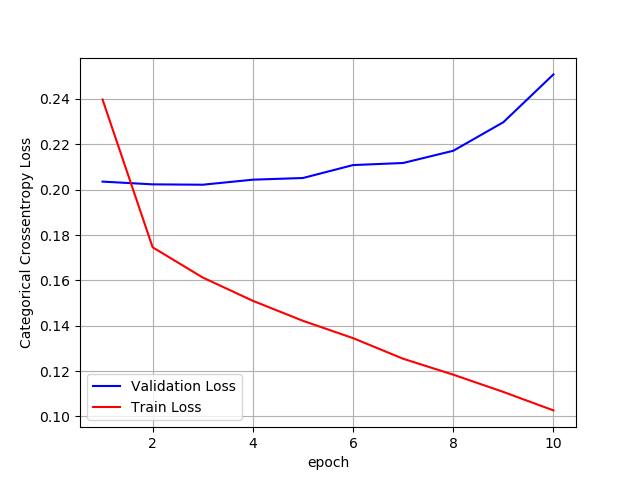

                        Sanity check                        


<IPython.core.display.Javascript object>


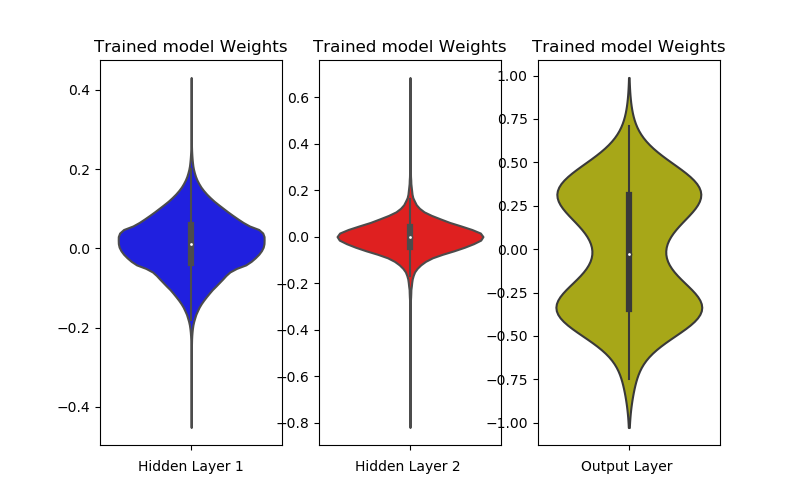

In [24]:
epochs=10
batch_size=1024
loss,acc = _plots( model = lstm,
                  history = history)

In [26]:
# Here, we are storing all the required results in a dataframe.

r_rand = {'model': ['RNN-1_LSTM'], 
         'Test Loss': loss,
         'Accuracy': acc, 
     }
r_df_rand = pd.DataFrame(data=r_rand)
r_df_rand

df2=result_append(df = r_df_rand,
                 wrd = r_df_rand['model'][0])
df2

Stored the data in new file


,model,Test Loss,Accuracy
0,RNN-1_LSTM,0.25083,0.91723


## 3.5 RNN with 2-LSTM layers

In [29]:
embedding_len=32

lstm=Sequential()
lstm.add(Embedding(vocab_len,
                   embedding_len,
                   input_length=max_review_length))

lstm.add(LSTM(75, return_sequences=True))
lstm.add(BatchNormalization())
         
lstm.add(LSTM(75))
lstm.add(Dropout(0.5))

lstm.add(Dense(1, activation='sigmoid'))

print(lstm.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 128, 32)           1889888   
_________________________________________________________________
lstm_5 (LSTM)                (None, 128, 75)           32400     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 75)           300       
_________________________________________________________________
lstm_6 (LSTM)                (None, 75)                45300     
_________________________________________________________________
dropout_4 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 76        
Total params: 1,967,964
Trainable params: 1,967,814
Non-trainable params: 150
________________________________________________________________

In [30]:
lstm.compile( loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

epochs=10
batch_size=1024
history = lstm.fit( x_train, 
                    y_train, 
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    shuffle=False,
                    validation_data=(x_test, y_test))

Train on 254786 samples, validate on 109194 samples
Epoch 1/10
254786/254786 [==============================] - 934s 4ms/step - loss: 0.2346 - acc: 0.9087 - val_loss: 0.2096 - val_acc: 0.9176
Epoch 2/10
254786/254786 [==============================] - 932s 4ms/step - loss: 0.1648 - acc: 0.9363 - val_loss: 0.2088 - val_acc: 0.9199
Epoch 3/10
254786/254786 [==============================] - 932s 4ms/step - loss: 0.1427 - acc: 0.9452 - val_loss: 0.2543 - val_acc: 0.9076
Epoch 4/10
254786/254786 [==============================] - 931s 4ms/step - loss: 0.1226 - acc: 0.9534 - val_loss: 0.2423 - val_acc: 0.9169
Epoch 5/10
254786/254786 [==============================] - 932s 4ms/step - loss: 0.1055 - acc: 0.9606 - val_loss: 0.2418 - val_acc: 0.9201
Epoch 6/10
254786/254786 [==============================] - 931s 4ms/step - loss: 0.0949 - acc: 0.9648 - val_loss: 0.2759 - val_acc: 0.9149
Epoch 7/10
254786/254786 [==============================] - 932s 4ms/step - loss: 0.0849 - acc: 0.9689 - val

In [31]:
result={'model':lstm,
       'history':history}

with open( './model/RNN_2_LSTM.pkl','wb') as fi:
    pickle.dump(result,fi)

Test score: 0.3050450456823222
Test accuracy: 0.9070278586746452


<IPython.core.display.Javascript object>


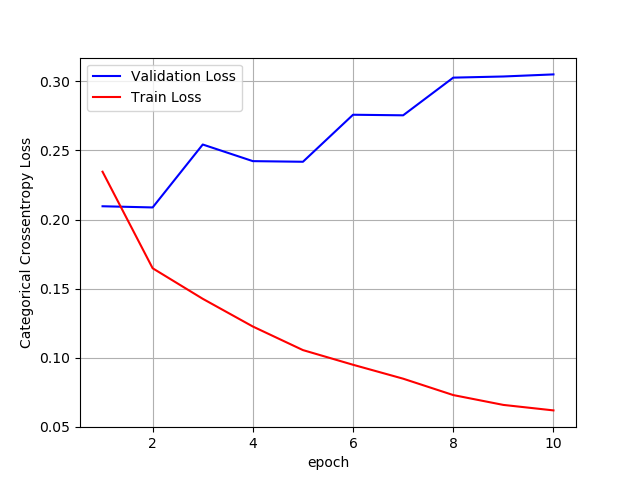

                        Sanity check                        


<IPython.core.display.Javascript object>


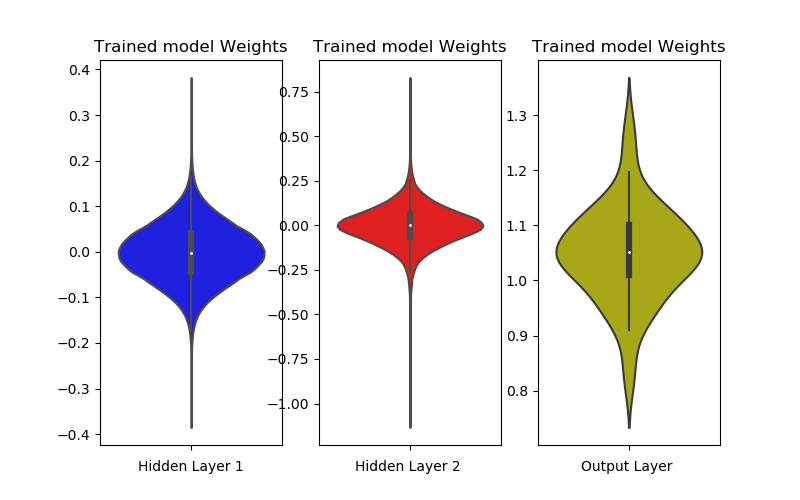

In [32]:
loss,acc = _plots( model = lstm,
                  history = history)

### Conclusion:
- Even with Batch normalization and Higher Dropout rates, 2-layer LSTM model is clearly overfitting more than 1-layer LSTM model.

In [33]:
# Here, we are storing all the required results in a dataframe.

r_rand = {'model': ['RNN-2_LSTM'], 
         'Test Loss': loss,
         'Accuracy': acc, 
     }
r_df_rand = pd.DataFrame(data=r_rand)
r_df_rand

df2=result_append(df = r_df_rand,
                 wrd = r_df_rand['model'][0])
df2

Appending the data


,model,Test Loss,Accuracy
0,RNN-1_LSTM,0.250830,0.917230
0,RNN-2_LSTM,0.305045,0.907028


# 4 Overall Conclusion: 

In [34]:
df1 = pd.DataFrame()
df1 = pd.read_excel('./outputs.xlsx')
df1

,model,Test Loss,Accuracy
0,RNN-1_LSTM,0.250830,0.917230
1,RNN-2_LSTM,0.305045,0.907028


## 4.1 Beautiful Table

In [35]:
from beautifultable import BeautifulTable

print("Algorithm table".center(50))

lr_table = BeautifulTable()
lr_table.column_headers = df1.columns
for ele in df1.values:
    lr_table.append_row(ele)

print(lr_table)

                 Algorithm table                  
+------------+-----------+----------+
|   model    | Test Loss | Accuracy |
+------------+-----------+----------+
| RNN-1_LSTM |   0.251   |  0.917   |
+------------+-----------+----------+
| RNN-2_LSTM |   0.305   |  0.907   |
+------------+-----------+----------+
